In [ ]:
import json
import random

## Bboxes extraction

In [ ]:
iou_info = []

with open('test_annotation.json') as f0: # annotations from POS1
  annotation = json.load(f0)

with open('test_questions.json') as f1: # questions from 3POS1
  questions = json.load(f1)['questions']

with open('test_annotation_bboxes_350.json') as f2:
  annotation_bboxes = json.load(f2)

for q in questions:

  new_datum = {}

  if q['question_index'] % 6 == 0:
    new_datum['image_index'] = q['image_index']
    new_datum['images_original'] = q['images']
    new_datum['images_shuffled'] = q['images_shuffled']

    q_tokens = q['question'].split()
    new_datum['target'] = [q_tokens[4], q_tokens[5][:-1]]

    target_bboxes = []
    biggest_bboxes = []
    smallest_bboxes = []

    for img_filename in q['images_shuffled']:

      biggest_bboxes_img = []
      smallest_bboxes_img = []

      img_id = img_filename.split('.')[0]

      for obj in annotation_bboxes[img_id]:
        if (obj['color'] == q_tokens[4] and obj['shape'] == q_tokens[5][:-1]):
          target_bboxes.append(obj['bbox'])

      max_area = annotation[img_id][0]['max_area']
      min_area = annotation[img_id][0]['min_area']

      for i, obj in enumerate(annotation[img_id][1]['objects']):
        if obj['area'] == max_area:
          biggest_bboxes_img.append(annotation_bboxes[img_id][i]['bbox'])
        if obj['area'] == min_area:
          smallest_bboxes_img.append(annotation_bboxes[img_id][i]['bbox'])
      
      biggest_bboxes.append(biggest_bboxes_img)
      smallest_bboxes.append(smallest_bboxes_img)

    new_datum['target_bboxes'] = target_bboxes
    new_datum['biggest_bboxes'] = biggest_bboxes
    new_datum['smallest_bboxes'] = smallest_bboxes

    iou_info.append(new_datum)



In [ ]:
iou_info[2]

{'biggest_bboxes': [[[11, 186, 83, 258]],
  [[248, 119, 312, 183]],
  [[215, 94, 279, 158], [267, 130, 331, 194]]],
 'image_index': 2,
 'images_original': ['27.png', '877.png', '899.png'],
 'images_shuffled': ['899.png', '27.png', '877.png'],
 'smallest_bboxes': [[[294, 255, 318, 279]],
  [[46, 263, 76, 293], [224, 199, 254, 229]],
  [[303, 50, 327, 74], [138, 54, 162, 78]]],
 'target': ['green', 'circle'],
 'target_bboxes': [[78, 82, 136, 140],
  [46, 263, 76, 293],
  [267, 130, 331, 194]]}

In [ ]:
with open('iou_info_350.json', 'w+') as f:
  json.dump(iou_info, f)

# Load Faster R-CNN detections

In [ ]:
!pip install mxnet==1.6.0
!pip install -U d2l -f https://d2l.ai/whl.html

import sys
import csv
import base64
import time
%matplotlib inline
from d2l import mxnet as d2l
from mxnet import image, npx
import numpy as np
import matplotlib.pyplot as plt

npx.set_np()

maxInt = sys.maxsize

while True:
    # decrease the maxInt value by factor 10 
    # as long as the OverflowError occurs.
    try:
        csv.field_size_limit(maxInt)
        break
    except OverflowError:
        maxInt = int(maxInt/10)

Looking in links: https://d2l.ai/whl.html
Requirement already up-to-date: d2l in /usr/local/lib/python3.6/dist-packages (0.14.3)


In [ ]:
FIELDNAMES = ["img_id", "img_h", "img_w", "objects_id", "objects_conf",
              "attrs_id", "attrs_conf", "num_boxes", "boxes", "features"]

def load_obj_tsv(fname, topk=None):

    data = []
    start_time = time.time()
    print("Start to load Faster-RCNN detected objects from %s" % fname)
    with open(fname) as f:
        reader = csv.DictReader(f, FIELDNAMES, delimiter="\t")
        for i, item in enumerate(reader):

            for key in ['img_h', 'img_w', 'num_boxes']:
                item[key] = int(item[key])
            
            boxes = item['num_boxes']
            decode_config = [
                ('objects_id', (boxes, ), np.int64),
                ('objects_conf', (boxes, ), np.float32),
                ('attrs_id', (boxes, ), np.int64),
                ('attrs_conf', (boxes, ), np.float32),
                ('boxes', (boxes, 4), np.float32),
                ('features', (boxes, -1), np.float32),
            ]
            for key, shape, dtype in decode_config:
                item[key] = np.frombuffer(base64.b64decode(item[key]), dtype=dtype)
                item[key] = item[key].reshape(shape)
                item[key].setflags(write=False)
            
            data.append(item)
            if topk is not None and len(data) == topk:
                break
    return data

In [ ]:
rcnn_data = load_obj_tsv("/content/drive/My Drive/test_obj36.tsv")

Start to load Faster-RCNN detected objects from /content/drive/My Drive/out_correct_order/test_obj36.tsv


## Actual analysis

In [ ]:
import csv
import json
import numpy as np
from operator import itemgetter 

In [ ]:
with open('test_predict_3img.csv', mode='r') as infile: # lxmert predictions on 3POS1 test set
  reader = csv.reader(infile)
  predicted = {rows[0] : 1 if rows[1] == 'True' else 0 for rows in reader}

with open('test.json') as f: # lxmert annotations for 3POS1
  dataset = json.load(f)

with open('iou_info_350.json') as f:
  gt_bboxes = json.load(f)

In [ ]:
correctly_predicted = []
for i, (key, value) in enumerate(predicted.items()):
  if dataset[i]['label'] == value:
    correctly_predicted.append(i)

In [ ]:
# attention weights extracted from LXMERT's cross-modality layer

atts = np.load("/content/drive/My Drive/att_scores_out_3img/0.npy", allow_pickle=True).item().get('cross')[8]
for i in range(1, 8):
  atts = np.concatenate((atts, np.load("/content/drive/My Drive/att_scores_out_3img/%s.npy"% str(i), allow_pickle=True).item().get('cross')[8]))

In [ ]:
scores = atts
scores[0][0][0, :]
atts[0][0].shape

(20, 36)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


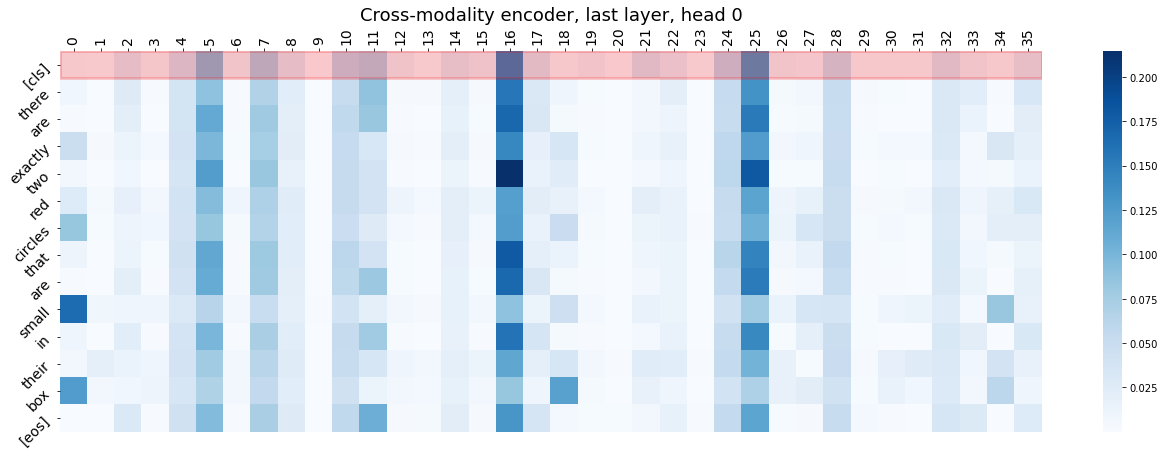

In [ ]:
import json
import matplotlib.pyplot as plt
import numpy as np
import seaborn
from matplotlib.patches import Rectangle

sent_str = '[cls] there are exactly two red circles that are small in their box [eos]'
sent = sent_str.split()
fig, ax = plt.subplots(figsize=(22,7))
ax.set_title("Cross-modality encoder, last layer, head 0", fontsize = 18)
plt.rcParams['ytick.left'] = True
sample = atts[171][0][:14]
seaborn.heatmap(sample, cmap="Blues")
ax.xaxis.set_ticks_position('top')
plt.xticks(np.arange(36)+0.5, range(0,36), rotation=90, fontsize = 14)
plt.yticks(np.arange(len(sent[:14]))+0.5, sent[:14], rotation=45, fontsize = 14)
ax.add_patch(Rectangle((0, 0), 36, 1, fill=True, edgecolor=(1,0,0,0.2), facecolor=(1,0,0,0.2),  lw=3))
plt.show()

In [ ]:
with open("/content/drive/My Drive/att_scores_out/attributes_vocab.txt") as f:
    attributes = f.readlines()

In [ ]:
with open("/content/drive/My Drive/att_scores_out/attributes_vocab.txt") as f:
  attributes = f.readlines()

attributes = [x.strip() for x in attributes] 

def get_top_k_attended_boxes(img_id, img_name, att_head, k=2):
  # a = sum(scores[img_id][:,0,:])

  # a = sum(sum(scores[img_id][:,1:,:]))

  # a = sum(scores[img_id][att_head])
  a = scores[img_id][att_head][0]
  background_ids = set(get_background_indices(img_name))

  topk = sorted(enumerate(a), key=lambda iv: -100 if iv[0] in background_ids else iv[1])[-k:]
  return [i for i, v in topk]
  # return random.sample(range(0, 36), k)

def get_background_indices(img_name):

  background_indices = []

  for datum in rcnn_data:
    if datum['img_id'] == img_name:
      for i, aid in enumerate(datum['attrs_id']):
        if (attributes[aid] == 'black' or attributes[aid] == 'dark'):
          background_indices.append(i)
      return background_indices

def get_bboxes(img_id, top_indices):
  for datum in rcnn_data:
    if datum['img_id'] == img_id:

      return itemgetter(*top_indices)(datum['boxes'])

def get_image_data(img_id):

  for datum in rcnn_data:
    if datum['img_id'] == img_id:
      return datum

In [ ]:
def bb_intersection_over_union(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
  max = __builtins__.max
  xA = max(boxA[0], boxB[0])
  yA = max(boxA[1], boxB[1])
  xB = min(boxA[2], boxB[2])
  yB = min(boxA[3], boxB[3])
  # compute the area of intersection rectangle
  interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	# compute the area of both the prediction and ground-truth
	# rectangles
  boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
  boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
  # compute the intersection over union by taking the intersection
  # area and dividing it by the sum of prediction + ground-truth
  # areas - the interesection area
  iou = interArea / float(boxAArea + boxBArea - interArea)
  # return the intersection over union value
  return iou

In [ ]:
for att_head in range(0,12):
  ious_target = []
  ious_biggest = []
  ious_smallest = []
  found_ids = []
  found_target = []
  found_biggest = []
  found_smallest = []
  for i in correctly_predicted:  
  # for i in [1]: 
    qid = i*3
    img_name0 = '%s-img0' % str(i)
    img_name1 = '%s-img1' % str(i)
    img_name2 = '%s-img2' % str(i)
    top_bboxes = []

    top0 = get_top_k_attended_boxes(qid, img_name0,  att_head)
    top1 = get_top_k_attended_boxes(qid+1, img_name0, att_head)
    top2 = get_top_k_attended_boxes(qid+2, img_name0, att_head)
    top_bboxes.append(get_bboxes(img_name0, top0))
    top_bboxes.append(get_bboxes(img_name1, top1))
    top_bboxes.append(get_bboxes(img_name2, top2))

    for j in range(3):
      max_iou=0.0
      for top_box in top_bboxes[j]:
        for gt_bbox in gt_bboxes[i]['biggest_bboxes'][j]:
          iou = bb_intersection_over_union(gt_bbox, top_box)
          if iou > max_iou:
            max_iou = iou
      ious_biggest.append(max_iou)
      if max_iou > 0.5:
        found_ids.append(i)
        found_biggest.append(i)

    for j in range(3):
      max_iou=0.0
      for top_box in top_bboxes[j]:
        for gt_bbox in gt_bboxes[i]['smallest_bboxes'][j]:
          iou = bb_intersection_over_union(gt_bbox, top_box)
          if iou > max_iou:
            max_iou = iou
      ious_smallest.append(max_iou)
      if max_iou > 0.5:
        found_ids.append(i)
        found_smallest.append(i)


    for j in range(3):
      max_iou=0.0
      for top_box in top_bboxes[j]:
        iou = bb_intersection_over_union(gt_bboxes[i]['target_bboxes'][j], top_box)
        if iou > max_iou:
          max_iou = iou
      ious_target.append(max_iou)
      if max_iou > 0.5:
        found_ids.append(i)
        found_target.append(i)

  print('HEAD:', att_head)
  print('target:', sum(i > 0.5 for i in ious_target), '%scenes:', len(set(found_target))/len(correctly_predicted))
  print('smallest:', sum(i > 0.5 for i in ious_smallest), '%scenes:', len(set(found_smallest))/len(correctly_predicted))
  print('biggest:', sum(i > 0.5 for i in ious_biggest), '%scenes:', len(set(found_biggest))/len(correctly_predicted))
  print('% of scenes:', len(set(found_ids))/len(correctly_predicted), '\n')

HEAD: 0
target: 1521 %scenes: 0.6649630891538898
smallest: 942 %scenes: 0.44349801249290177
biggest: 236 %scenes: 0.12890403180011356
% of scenes: 0.8472458830210108 

HEAD: 1
target: 1735 %scenes: 0.7086882453151618
smallest: 815 %scenes: 0.3850085178875639
biggest: 206 %scenes: 0.11186825667234526
% of scenes: 0.8449744463373083 

HEAD: 2
target: 1677 %scenes: 0.7109596819988643
smallest: 1073 %scenes: 0.49687677455990914
biggest: 50 %scenes: 0.027825099375354913
% of scenes: 0.8642816581487791 

HEAD: 3
target: 1235 %scenes: 0.555366269165247
smallest: 1269 %scenes: 0.5678591709256104
biggest: 57 %scenes: 0.031232254400908575
% of scenes: 0.8268029528676888 

HEAD: 4
target: 1412 %scenes: 0.6218057921635435
smallest: 1700 %scenes: 0.6973310618966496
biggest: 40 %scenes: 0.022714366837024418
% of scenes: 0.8949460533787621 

HEAD: 5
target: 1570 %scenes: 0.6621237932992617
smallest: 1390 %scenes: 0.5945485519591142
biggest: 261 %scenes: 0.14310051107325383
% of scenes: 0.886428165814

random

In [ ]:
for att_head in range(0,12):
  ious_target = []
  ious_biggest = []
  ious_smallest = []
  found_ids = []
  found_target = []
  found_biggest = []
  found_smallest = []
  for i in correctly_predicted:  
  # for i in [1]: 
    qid = i*3
    img_name0 = '%s-img0' % str(i)
    img_name1 = '%s-img1' % str(i)
    img_name2 = '%s-img2' % str(i)
    top_bboxes = []

    top0 = get_top_k_attended_boxes(qid, img_name0,  att_head)
    top1 = get_top_k_attended_boxes(qid+1, img_name0, att_head)
    top2 = get_top_k_attended_boxes(qid+2, img_name0, att_head)
    top_bboxes.append(get_bboxes(img_name0, top0))
    top_bboxes.append(get_bboxes(img_name1, top1))
    top_bboxes.append(get_bboxes(img_name2, top2))

    for j in range(3):
      max_iou=0.0
      for top_box in top_bboxes[j]:
        for gt_bbox in gt_bboxes[i]['biggest_bboxes'][j]:
          iou = bb_intersection_over_union(gt_bbox, top_box)
          if iou > max_iou:
            max_iou = iou
      ious_biggest.append(max_iou)
      if max_iou > 0.5:
        found_ids.append(i)
        found_biggest.append(i)

    for j in range(3):
      max_iou=0.0
      for top_box in top_bboxes[j]:
        for gt_bbox in gt_bboxes[i]['smallest_bboxes'][j]:
          iou = bb_intersection_over_union(gt_bbox, top_box)
          if iou > max_iou:
            max_iou = iou
      ious_smallest.append(max_iou)
      if max_iou > 0.5:
        found_ids.append(i)
        found_smallest.append(i)


    for j in range(3):
      max_iou=0.0
      for top_box in top_bboxes[j]:
        iou = bb_intersection_over_union(gt_bboxes[i]['target_bboxes'][j], top_box)
        if iou > max_iou:
          max_iou = iou
      ious_target.append(max_iou)
      if max_iou > 0.5:
        found_ids.append(i)
        found_target.append(i)

  print('HEAD:', att_head)
  print('target:', sum(i > 0.5 for i in ious_target), '%scenes:', len(set(found_target))/len(correctly_predicted))
  print('smallest:', sum(i > 0.5 for i in ious_smallest), '%scenes:', len(set(found_smallest))/len(correctly_predicted))
  print('biggest:', sum(i > 0.5 for i in ious_biggest), '%scenes:', len(set(found_biggest))/len(correctly_predicted))
  print('% of scenes:', len(set(found_ids))/len(correctly_predicted), '\n')

HEAD: 0
target: 659 %scenes: 0.3282226007950028
smallest: 668 %scenes: 0.32935831913685404
biggest: 937 %scenes: 0.4332765474162408
% of scenes: 0.7098239636570131 

HEAD: 1
target: 735 %scenes: 0.36740488358886997
smallest: 675 %scenes: 0.33106189664963087
biggest: 972 %scenes: 0.4565587734241908
% of scenes: 0.7251561612720046 

HEAD: 2
target: 739 %scenes: 0.3634298693923907
smallest: 665 %scenes: 0.3316297558205565
biggest: 1006 %scenes: 0.47132311186825665
% of scenes: 0.7416240772288473 

HEAD: 3
target: 695 %scenes: 0.3418512208972175
smallest: 724 %scenes: 0.35036910846110164
biggest: 943 %scenes: 0.4440658716638274
% of scenes: 0.727427597955707 

HEAD: 4
target: 739 %scenes: 0.3639977285633163
smallest: 740 %scenes: 0.35491198182850653
biggest: 990 %scenes: 0.4645088018171493
% of scenes: 0.7427597955706985 

HEAD: 5
target: 770 %scenes: 0.380465644520159
smallest: 695 %scenes: 0.3390119250425894
biggest: 999 %scenes: 0.4593980692788189
% of scenes: 0.7393526405451448 

HEAD:

 Some example visualisations

In [ ]:
def show_bboxes(axes, bboxes, labels=None, colors=None):
    def _make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj
    labels = _make_list(labels)
    colors = _make_list(colors, [(1,0,1), (0,0,1)])
    # colors = [(210, 52, 235, 0.2), (52, 235, 137, 0.2)]
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = bbox_to_rect(bbox, color)
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i],
                      va='center', ha='center', fontsize=9, color=text_color,
                      bbox=dict(facecolor=color, lw=0))

In [ ]:
def bbox_to_rect(bbox, color):
    return d2l.plt.Rectangle(
        xy=(bbox[0], bbox[1]), width=bbox[2]-bbox[0], height=bbox[3]-bbox[1],
        fill=False, edgecolor=color, facecolor = color, linewidth=3)

In [ ]:
top0=get_top_k_attended_boxes(759, '759-img0', 11,k=5)
top_bboxes=get_bboxes('%s-img0' % 759, top0)

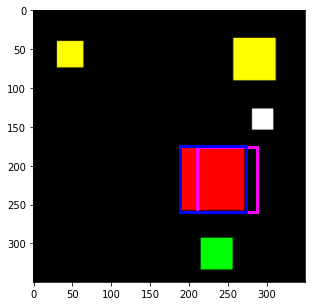

In [ ]:
from operator import itemgetter 

img_file = '1006-img2.png'

plt.figure(figsize=(5,5))

img = image.imread(img_file).asnumpy()

# labels = get_detected_labels(img_file.split('.')[0])
labels = []

to_display = top0
fig = d2l.plt.imshow(img)

boxes = [top_bboxes[1]]
# for b in top_bboxes:
#   boxes.append(b)

boxes.append(gt_bboxes[1006]['biggest_bboxes'][2][0])
show_bboxes(fig.axes, boxes)

# to_display = iou_info[0]['target_bboxes'][1]
fig = d2l.plt.imshow(img)

# show_bboxes(fig.axes, top_bboxes,
#             labels)

In [ ]:
for i, b in enumerate(top_bboxes):    
  iou = bb_intersection_over_union(gt_bboxes[1006]['biggest_bboxes'][2][0], b)
  print(i, iou)

0 0.0
1 0.6229362506238719
2 0.277076715220451
3 0.0
4 0.0


In [ ]:
for i, b in enumerate(top_bboxes):    
  iou = bb_intersection_over_union(gt_bboxes[759]['target_bboxes'][0], b)
  print(i, iou)

0 0.0
1 0.3103228734802371
2 0.0
3 0.25317743486109173
4 0.0


[array([187.47957, 193.45874, 338.9198 , 335.88757], dtype=float32), [214, 208, 328, 266], array([132.04669 ,   7.521473, 190.1398  ,  40.78276 ], dtype=float32)]


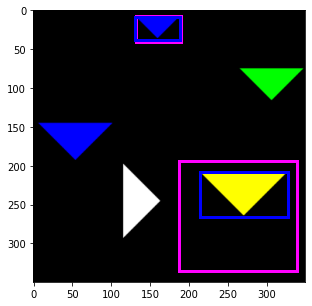

In [ ]:
from operator import itemgetter 

img_file = '759-img0.png'

plt.figure(figsize=(5,5))

img = image.imread(img_file).asnumpy()

# labels = get_detected_labels(img_file.split('.')[0])
labels = []

to_display = top0
fig = d2l.plt.imshow(img)

boxes = [top_bboxes[1], gt_bboxes[759]['target_bboxes'][0], top_bboxes[4]]
print(boxes)
# boxes = []
# for b in top_bboxes:
#   boxes.append(b)

boxes.append(gt_bboxes[759]['smallest_bboxes'][0][0])
show_bboxes(fig.axes, boxes)

# to_display = iou_info[0]['target_bboxes'][1]
fig = d2l.plt.imshow(img)

# show_bboxes(fig.axes, top_bboxes,
#             labels)